<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_ensemble_stock_trading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-udv08fu2
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-udv08fu2
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-0lbbb89b/pyfolio_7f12ee8e09cb45d3afc00846b17ade8f
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-0lbbb89b/pyfolio_7f12ee8e09cb45d3afc00846b17ade8f
     |████████████████████████████████| 49.6 MB 1.1 MB/s 
     |████████████████████████████████| 1.8 MB 750 kB/s 
     |████████████████████████████████| 124 kB 658 kB/s 
     |████████████████████████████████| 108 kB 285 kB/s 
     |████████████████████████████████| 43 kB 231 kB/s 
     |████████████████████████████████| 2.0 MB 1.3 MB/s 
     |████████████████████████████████| 153 kB 1.0 MB/s 
     |████████████████████████████████| 52 kB 254 kB/s 
     |████████████████████████████████| 1.3 MB 630 kB/s 
     |████████████████


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
df = YahooDownloader(start_date = '2016-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.SENSEX_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4
1,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4
2,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4
3,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4
4,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4


In [7]:
df.tail()

,date,open,high,low,close,volume,tic,day
36955,2020-12-31,586.799988,594.799988,582.150024,585.673584,3112952.0,SUNPHARMA.BO,3
36956,2020-12-31,2902.000000,2906.050049,2845.000000,2844.595703,834286.0,TCS.BO,3
36957,2020-12-31,987.000000,987.000000,968.950012,947.596375,51689.0,TECHM.BO,3
36958,2020-12-31,1553.050049,1571.650024,1543.650024,1563.746460,87393.0,TITAN.BO,3
36959,2020-12-31,5387.700195,5387.700195,5265.000000,5259.089844,27520.0,ULTRACEMCO.BO,3


In [8]:
df.shape

(36960, 8)

In [9]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4
1,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4
2,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4
3,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4
4,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4


In [10]:
len(df.tic.unique())

30

In [11]:
df.tic.value_counts()

HDFC.BO          1232
NESTLEIND.BO     1232
HDFCBANK.BO      1232
ONGC.BO          1232
SUNPHARMA.BO     1232
ITC.BO           1232
BAJAJFINSV.BO    1232
TCS.BO           1232
NTPC.BO          1232
ULTRACEMCO.BO    1232
MARUTI.BO        1232
TECHM.BO         1232
BAJAJ-AUTO.BO    1232
BHARTIARTL.BO    1232
ASIANPAINT.BO    1232
DRREDDY.BO       1232
M&M.BO           1232
SBIN.BO          1232
AXISBANK.BO      1232
LT.BO            1232
TITAN.BO         1232
HCLTECH.BO       1232
INDUSINDBK.BO    1232
INFY.BO          1232
POWERGRID.BO     1232
BAJFINANCE.BO    1232
KOTAKBANK.BO     1232
RELIANCE.BO      1232
HINDUNILVR.BO    1232
ICICIBANK.BO     1232
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [12]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')

In [13]:
# tech_indicators = ['macd',
#  'rsi_30',
#  'cci_30',
#  'dx_30']

In [14]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    use_vix=False,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = True)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added Sentiment Features
Successfully added user defined features


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,tweets,news,daily_return,return_lag_1,return_lag_2
28187,2019-10-30,612.0,618.099976,605.049988,607.232300,117525.0,M&M.BO,2,13.936376,606.587149,...,57.667369,175.770187,34.128374,557.676607,541.689214,0.102517,0.073607,0.009164,0.066586,0.061354
24169,2019-04-08,11010.0,11021.000000,10840.200195,10344.758789,1695.0,NESTLEIND.BO,0,65.779239,10648.175603,...,51.448565,99.107030,8.220644,10116.632454,10376.820508,0.112334,-0.127714,-0.011013,-0.008453,-0.011296
20778,2018-10-22,6839.0,6899.649902,6726.299805,6618.117676,74851.0,MARUTI.BO,0,-399.831899,7852.533286,...,34.176227,-91.595128,46.942291,7471.483138,8192.790755,0.131960,0.133541,0.007936,-0.009406,-0.046986
17412,2018-05-09,1860.0,1890.000000,1860.000000,1838.499390,39924.0,INDUSINDBK.BO,2,22.322838,1871.631958,...,58.040572,65.896348,2.176916,1815.655444,1738.601536,-0.011601,0.000000,0.002276,-0.006897,-0.007845
6553,2016-11-23,462.0,462.000000,456.600006,406.090942,342490.0,INFY.BO,2,-11.825710,454.657170,...,36.216050,-111.924359,57.157721,432.649276,443.785654,0.031997,0.022681,0.007167,0.010262,0.000761


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
train = data_split(processed, '2016-01-01','2019-07-01')
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,tweets,news,daily_return,return_lag_1,return_lag_2
0,2016-01-06,906.000000,912.000000,883.950012,853.923279,187735.0,ASIANPAINT.BO,2,0.380458,872.990964,...,58.301593,60.279597,54.290436,854.404861,854.404861,0.800036,0.059280,-0.015874,0.006700,0.007271
0,2016-01-06,439.700012,439.700012,429.799988,422.130493,730512.0,AXISBANK.BO,2,-0.639598,445.849726,...,0.000000,-86.940415,100.000000,430.214470,430.214470,-0.004242,0.115783,-0.012719,-0.019237,-0.042241
0,2016-01-06,2495.000000,2513.699951,2475.000000,2108.613281,11975.0,BAJAJ-AUTO.BO,2,-0.849310,2145.600723,...,17.219847,-94.324774,100.000000,2118.952576,2118.952576,0.000000,0.003962,-0.004625,-0.001065,-0.013710
0,2016-01-06,1940.000000,1954.750000,1932.000000,1938.521851,2052.0,BAJAJFINSV.BO,2,-1.526875,1993.066264,...,0.000000,-88.366896,100.000000,1954.562622,1954.562622,-0.069511,-0.043120,-0.001515,-0.009830,-0.021196
0,2016-01-06,597.900024,618.000000,595.559998,605.033569,22360.0,BAJFINANCE.BO,2,0.137747,609.726318,...,61.519051,106.672756,56.426448,598.658127,598.658127,0.096922,-0.029449,0.022184,0.013141,0.007532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,2019-06-28,405.850006,409.700012,398.250000,390.352905,381226.0,SUNPHARMA.BO,4,-6.450453,406.149868,...,45.500897,10.540080,13.645589,390.421046,415.639042,0.074625,0.057017,-0.004469,0.004257,0.040343
856,2019-06-28,2255.000000,2261.250000,2222.949951,2118.549561,99596.0,TCS.BO,4,30.868157,2191.806528,...,56.343044,49.432221,2.082357,2076.118197,2038.381641,0.148089,0.034361,-0.011276,-0.011736,-0.017426
856,2019-06-28,709.000000,715.000000,704.400024,646.470215,107082.0,TECHM.BO,4,-13.522017,708.491738,...,39.033539,-166.271726,46.783293,679.987457,706.450402,0.112652,0.067579,0.006126,-0.016639,-0.025190
856,2019-06-28,1320.000000,1336.800049,1318.000000,1315.642456,31463.0,TITAN.BO,4,30.528909,1317.760233,...,67.726468,155.000128,48.424734,1247.607454,1176.327264,0.069511,0.014545,0.004553,0.019514,0.012592


In [17]:
sent = 1
tech = 1
user = 1
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 451


In [18]:
env_kwargs = {
    "hmax": 1000, 
    "initial_amount": 10000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    # "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2016-01-01'
train_end = '2019-07-01'
val_test_start = '2019-07-01'
val_test_end = '2021-01-01'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

TypeError: __init__() got an unexpected keyword argument 'sentiment_indicator_list'

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  208.11619437156776
======Model training from:  2009-01-01 to  2020-04-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_3
------------------------------------
| time/                 |          |
|    fps                | 85       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.0748   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -60.3    |
|    std                | 1        |
|    value_loss         | 2.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 200      |
|    time_

In [ ]:
df_summary

NameError: ignored

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [20]:
# initialize
agent = DRLAgent(env = env_train)
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_2
------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | 395      |
|    std                | 1        |
|    value_loss         | 172      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 100      |
|    iterations         | 200      |
|    time_elapsed       | 9        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.8    |
|    explained_variance | 1.19e-07 |


In [23]:
trade = data_split(processed,'2019-07-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [24]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [25]:
df_actions.to_csv('df_actions.csv')

In [26]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [27]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.124088
Cumulative returns     0.188477
Annual volatility      0.364000
Sharpe ratio           0.505400
Calmar ratio           0.304183
Stability              0.028510
Max drawdown          -0.407938
Omega ratio            1.105196
Sortino ratio          0.715256
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.834523
Daily value at risk   -0.045130
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (371, 8)


Start date,2019-07-01
End date,2020-12-31
Total months,17
,Backtest
Annual return,12.409%
Cumulative returns,18.848%
Annual volatility,36.4%
Sharpe ratio,0.51
Calmar ratio,0.30
Stability,0.03
Max drawdown,-40.794%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.79,2020-01-17,2020-04-03,2020-11-17,218
1,12.66,2019-07-04,2019-09-04,2019-09-23,58
2,7.40,2019-09-24,2019-10-07,2019-10-17,18
3,6.99,2019-10-29,2019-12-12,2020-01-13,55
4,4.60,2020-12-08,2020-12-21,2020-12-30,17


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2020-01-01 00:00:00+00:00'], dtype='datetime64[ns, UTC]', name='date', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

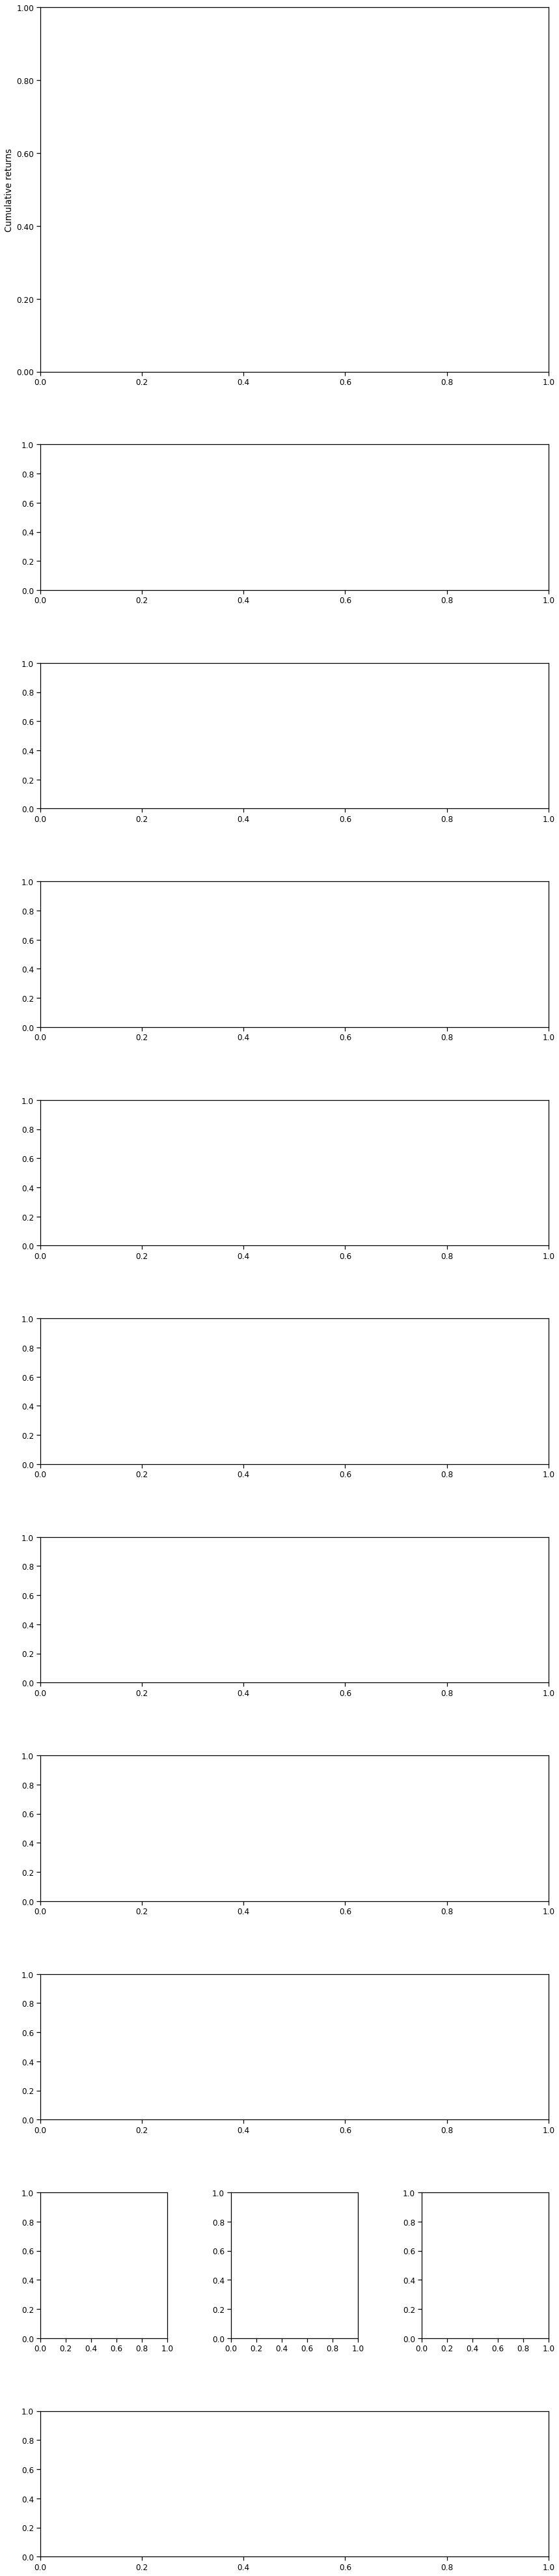

In [29]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-07-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)